In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

import time

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 1.0  # final time
rA = 1.5   # maximum interaction distance

seed=17

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a': 7.51}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [4]:
force_names = ['cubic', 'pw. quad.', 'GLS']
solver_names = ['EF', 'EB']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.'}

In [5]:
models_ef = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), ef.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), ef.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), ef.solve_ivp, 1)}
models_eb = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), eb.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), eb.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), eb.solve_ivp, 1)}
model_dicts = {'EF': models_ef, 'EB': models_eb}

In [6]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=True), cl.Cell(1, [0.3], proliferating=True)]


In [7]:
dt = 0.1
N = int(1/dt) + 1
t_data = np.arange(0,1,dt)

In [9]:
etas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
sol1 = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for eta in etas:
    for force in force_names:
        _, ref = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': model_dicts['EB'][force].jacobian}, seed=seed)
        y_ref = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in ref]))
        _, history = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt, 'eta': eta}, seed=seed)
        y = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in history]))
        sol1[force].append(np.linalg.norm(y-y_ref)/np.linalg.norm(y_ref))
        

In [10]:
dt = 0.01
N = int(1/dt) + 1
t_data = np.arange(0,1,dt)
etas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
sol2 = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for eta in etas:
    for force in force_names:
        _, ref = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': model_dicts['EB'][force].jacobian}, seed=seed)
        y_ref = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in ref]))
        _, history = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt, 'eta': eta}, seed=seed)
        y = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in history]))
        sol2[force].append(np.linalg.norm(y-y_ref)/np.linalg.norm(y_ref))

In [15]:
dt = 0.001
N = int(1/dt) + 1
t_data = np.arange(0,1,dt)
etas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
sol3 = {'cubic': [], 'pw. quad.': [], 'GLS': []}

exec_ref = []
exec_times = []
for eta in etas:
    for force in force_names:
        start_ref = time.time()
        _, ref = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': model_dicts['EB'][force].jacobian}, seed=seed)
        exec_ref.append(time.time() - start_ref)
        y_ref = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in ref]))
        start = time.time()
        _, history = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt, 'eta': eta}, seed=seed)
        exec_times.append(time.time() - start)
        y = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in history]))
        sol3[force].append(np.linalg.norm(y-y_ref)/np.linalg.norm(y_ref))

In [16]:
np.mean(exec_ref)

0.7383280277252198

In [17]:
np.mean(exec_times)

0.7287783145904541

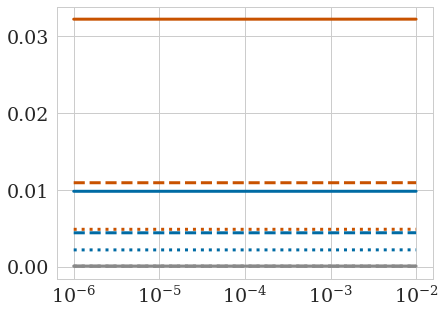

In [18]:
for force in force_names:
    plt.semilogx(etas, sol1[force], label=force+', $\Delta t=0.1$', color=colors[force])
    plt.semilogx(etas, sol2[force], label=force+', $\Delta t=0.01$', color=colors[force], linestyle='--')
    plt.semilogx(etas, sol3[force], label=force+', $\Delta t=0.001$', color=colors[force], linestyle=':')
#plt.legend()

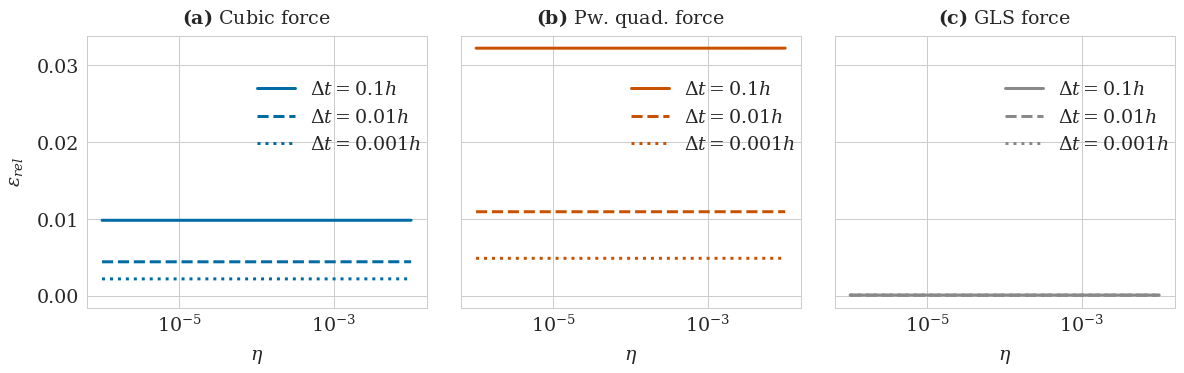

In [19]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19.5, 5), sharey=True, gridspec_kw={'wspace': 0.1})

# ax1
force='cubic'
ax1.semilogx(etas, sol1[force], label='$\Delta t=0.1h$', color=colors[force])
ax1.semilogx(etas, sol2[force], label='$\Delta t=0.01h$', color=colors[force], linestyle='--')
ax1.semilogx(etas, sol3[force], label='$\Delta t=0.001h$', color=colors[force], linestyle=':')
ax1.legend(loc='center left', bbox_to_anchor=(0.45,0.7))
#plt.legend()
ax1.set(xlabel='$\eta$')
ax1.set_title(r'$\bf{(a)}$ Cubic force')
ax1.set(ylabel='$\epsilon_{rel}$')
#ax1.set_xlim([7*1e-4, 5*1e-1])
#ax1.set_ylim([5*1e-10, 10*1e-0])
#ax1.set_xticklabels([])
#ax1.set_ylim([5*1e-8, 5*1e-0])


#ax2
force='pw. quad.'
ax2.semilogx(etas, sol1[force], label='$\Delta t=0.1h$', color=colors[force])
ax2.semilogx(etas, sol2[force], label='$\Delta t=0.01h$', color=colors[force], linestyle='--')
ax2.semilogx(etas, sol3[force], label='$\Delta t=0.001h$', color=colors[force], linestyle=':')
ax2.legend(loc='center left', bbox_to_anchor=(0.45,0.7))
ax2.set(xlabel='$\eta$')
#ax2.set_xlim([7*1e-4, 5*1e-1])
ax2.set_title(r'$\bf{(b)}$ Pw. quad. force')
#ax2.set_xticklabels([])

#ax2
force='GLS'
ax3.semilogx(etas, sol1[force], label='$\Delta t=0.1h$', color=colors[force])
ax3.semilogx(etas, sol2[force], label='$\Delta t=0.01h$', color=colors[force], linestyle='--')
ax3.semilogx(etas, sol3[force], label='$\Delta t=0.001h$', color=colors[force], linestyle=':')
ax3.legend(loc='center left', bbox_to_anchor=(0.45,0.7))
ax3.set(xlabel='$\eta$')
ax3.set_title(r'$\bf{(c)}$ GLS force')

plt.savefig('accuracy_dependence_eta.pdf', bbox_inches='tight')


In [20]:
dim = 2
models_ef = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBMModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBMModel(ff.Gls(), ef.solve_ivp, dim)}
models_eb = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), eb.solve_ivp, dim), 
             'cubic': cbmos.CBMModel(ff.Cubic(), eb.solve_ivp, dim),
             'GLS': cbmos.CBMModel(ff.Gls(), eb.solve_ivp, dim)}
model_dicts = {'EF': models_ef, 'EB': models_eb}

In [22]:
import scipy.integrate as sci_integr


In [26]:
# 2D honeycomb mesh
n_x = 5
n_y = 5
xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

# make cell_list for the sheet
sheet = [cl.Cell(i, [x, y], -6.0, True, lambda t: 6 + t)
         for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]
# delete cells to make it circular
del sheet[24]
del sheet[20]
del sheet[19]
del sheet[9]
del sheet[4]
del sheet[0]

# prepare consistent initial data
solver_scipy = cbmos.CBMModel(ff.PiecewisePolynomial(),
                              sci_integr.solve_ivp, dim)
t_data_init = [0, 0.0001]
(t_data, initial_sheet) = solver_scipy.simulate(sheet, t_data_init,
                                                {'muA': 0.21*9.1,
                                                 'muR': 9.1, 'rA': rA,
                                                 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0),
                                                 'n': 1.0, 'p': 1.0
                                                },
                                                {}, seed=seed)
initial_sheet = initial_sheet[-1]

In [37]:
dt = 0.001
N = int(1/dt) + 1
t_data = np.arange(0,1,dt)
etas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
sol3 = {'cubic': [], 'pw. quad.': [], 'GLS': []}

exec_ref = []
exec_times = []
eta = 0.001
for _ in range(10):
    for force in force_names:
        start_ref = time.time()
        _, ref = model_dicts['EB'][force].simulate(initial_sheet, t_data, params[force], {'dt': dt, 'jacobian': model_dicts['EB'][force].jacobian}, seed=seed)
        exec_ref.append(time.time() - start_ref)
#        y_ref = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in ref]))
        start = time.time()
        _, history = model_dicts['EB'][force].simulate(initial_sheet, t_data, params[force], {'dt': dt, 'eta': eta}, seed=seed)
        exec_times.append(time.time() - start)
#        y = np.squeeze(np.array([np.abs(clt[1].position - clt[0].position) for clt in history]))
#        sol3[force].append(np.linalg.norm(y-y_ref)/np.linalg.norm(y_ref))

In [38]:
np.mean(exec_ref)

1.8230469624201457

In [39]:
np.mean(exec_times)

2.03626602490743